<table align="center" width=100%>
    <tr>
        <td width="15%">
            <img src="healthinsurance.png">
        </td>
        <td>
            <div align="center">
                <font color="#21618C" size=24px>
                    <b>Recommendation Systems
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

## Context

This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.

## Data Definition

### Anime.csv

**anime_id** - myanimelist.net's unique id identifying an anime.

**name** - full name of anime.

**genre** - comma separated list of genres for this anime.

**type** - movie, TV, OVA, etc.

**episodes** - how many episodes in this show. (1 if movie).

**rating** - average rating out of 10 for this anime.

**members** - number of community members that are in this anime's "group".


### Rating.csv

**user_id** - non identifiable randomly generated user id.

**anime_id** - the anime that this user has rated.

**rating** - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

## Objective

To build a better anime recommendation system based on user viewing history.

## Table of Content

1. **[Popularity based recommendation system](#System3)**

2. **[Content-based recommendation system](#System4)** 

3. **[Collaborative recommendation system](#System5)** 

4. **[Hybrid Recommender Systems ](#Hybrid)**

5. **[Association rule](#System4)** 

6. **[Apriori algorithm](#System5)** 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans, accuracy
from scipy.sparse.linalg import svds
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import plotly.express as px

## Read Data

In [2]:
anime_df = pd.read_csv('anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
ratings_df = pd.read_csv('rating.csv')
ratings_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Data Analysis and Preparation

### Understand the Dataset

#### 1. Data Dimension

In [4]:
anime_df.shape

(12294, 7)

The anime dataframe has 7 columns and 12294 observations

In [5]:
ratings_df.shape

(7813737, 3)

The ratings dataframe has 3 columns and 7813737 observations

#### 2. Data Types

In [6]:
anime_df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [7]:
ratings_df.dtypes

user_id     int64
anime_id    int64
rating      int64
dtype: object

#### 3. Checking for Duplicates

In [8]:
anime_df[anime_df.duplicated()]

,anime_id,name,genre,type,episodes,rating,members


No duplicate observations found from the anime dataset

## Popularity Based Recommendation System

### Method 1 : Based on the rating feature of the anime dataset

#### 1. Creating a copy of anime dataset

In [9]:
anime = anime_df.copy()
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


#### 2. Grouping by name and sorting by average rating in descending order

In [10]:
pd.DataFrame(anime.groupby('name')['rating'].mean().sort_values(ascending=False))

,rating
name,
Taka no Tsume 8: Yoshida-kun no X-Files,10.00
Spoon-hime no Swing Kitchen,9.60
Mogura no Motoro,9.50
Kimi no Na wa.,9.37
Kahei no Umi,9.33
...,...
Yuuki Yuuna wa Yuusha de Aru: Yuusha no Shou,NaN
Yuyushiki Special,NaN
Zero kara Hajimeru Mahou no Sho,NaN


##### ** Top 10 animes in terms of average rating **

In [11]:
pd.DataFrame(anime.groupby('name')['rating'].mean().sort_values(ascending=False)).head(10)

,rating
name,
Taka no Tsume 8: Yoshida-kun no X-Files,10.00
Spoon-hime no Swing Kitchen,9.60
Mogura no Motoro,9.50
Kimi no Na wa.,9.37
Kahei no Umi,9.33
Fullmetal Alchemist: Brotherhood,9.26
Gintama°,9.25
Yakusoku: Africa Mizu to Midori,9.25
Steins;Gate,9.17


### Method 2 : Based on the Product of rating_user and rating_counts

#### 1. Merging the 2 datasets - anime and ratings

In [12]:
anime_data = pd.merge(ratings_df, anime, on='anime_id',suffixes= ['_user',''])
anime_data.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,6,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,10,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297


#### 2. Converting "-1" to "NaN"

In [13]:
# -1 if the user watched it but didn't assign a rating

In [14]:
anime_data['rating_user'].value_counts()

 8     1646019
-1     1476488
 7     1375287
 9     1254094
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating_user, dtype: int64

In [15]:
anime_data = anime_data.replace({-1:np.nan})
anime_data.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1.0,20.0,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
1,3.0,20.0,8.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
2,5.0,20.0,6.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
3,6.0,20.0,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
4,10.0,20.0,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0


In [16]:
anime_data['rating_user'].value_counts()

8.0     1646019
7.0     1375287
9.0     1254094
10.0     955715
6.0      637775
5.0      282806
4.0      104291
3.0       41453
2.0       23150
1.0       16649
Name: rating_user, dtype: int64

#### 3. Dropping duplicates

In [17]:
anime_data[anime_data.duplicated()]

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
804208,42653.0,16498.0,8.0,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229.0


In [18]:
anime_data = anime_data.drop_duplicates()

In [19]:
anime_data[anime_data.duplicated()]

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members


#### 4. Finding the average user rating for each anime and the number of times each anime has been rated (rating_counts)

In [20]:
ratings_mean_count = pd.DataFrame(anime_data.groupby('name')['rating_user'].mean())

In [21]:
ratings_mean_count['rating_counts'] = pd.DataFrame(anime_data.groupby('name')['rating_user'].count())

In [22]:
ratings_mean_count.head()

,rating_user,rating_counts
name,,
&quot;0&quot;,4.764706,17
"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",1.000000,1
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,7.343307,635
&quot;Bungaku Shoujo&quot; Memoire,7.744713,662
&quot;Bungaku Shoujo&quot; Movie,7.840154,1295


#### 5. Finding the product of rating_user and rating_counts

In [23]:
ratings_mean_count['product'] = ratings_mean_count['rating_counts'] * ratings_mean_count['rating_user']
ratings_mean_count.head(10)

,rating_user,rating_counts,product
name,,,
&quot;0&quot;,4.764706,17,81.0
"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",1.000000,1,1.0
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,7.343307,635,4663.0
&quot;Bungaku Shoujo&quot; Memoire,7.744713,662,5127.0
&quot;Bungaku Shoujo&quot; Movie,7.840154,1295,10153.0
&quot;Eiji&quot;,6.285714,14,88.0
.hack//G.U. Returner,7.024621,528,3709.0
.hack//G.U. Trilogy,7.458880,839,6258.0
.hack//G.U. Trilogy: Parody Mode,6.707031,256,1717.0


##### ** Top 10 animes in terms of product of rating_user and rating_counts **

In [24]:
ratings_mean_count_sorted = ratings_mean_count.sort_values(by='product', ascending=False)
ratings_mean_count_sorted.head(10)

,rating_user,rating_counts,product
name,,,
Death Note,8.834629,34226,302374.0
Shingeki no Kyojin,8.725770,25289,220666.0
Code Geass: Hangyaku no Lelouch,8.927796,24126,215392.0
Sword Art Online,8.140213,26310,214169.0
Angel Beats!,8.549714,23565,201474.0
Fullmetal Alchemist: Brotherhood,9.322741,21494,200383.0
Code Geass: Hangyaku no Lelouch R2,9.059837,21124,191380.0
Elfen Lied,8.064434,23528,189740.0
Fullmetal Alchemist,8.453356,21332,180327.0


##### (or) ** Top 10 animes in terms of rating_counts > 20,000 **

In [25]:
ratings_mean_count_filtered = ratings_mean_count[ratings_mean_count['rating_counts']>20000]
ratings_mean_count_filtered.sort_values(by='product', ascending=False).head(10)

,rating_user,rating_counts,product
name,,,
Death Note,8.834629,34226,302374.0
Shingeki no Kyojin,8.725770,25289,220666.0
Code Geass: Hangyaku no Lelouch,8.927796,24126,215392.0
Sword Art Online,8.140213,26310,214169.0
Angel Beats!,8.549714,23565,201474.0
Fullmetal Alchemist: Brotherhood,9.322741,21494,200383.0
Code Geass: Hangyaku no Lelouch R2,9.059837,21124,191380.0
Elfen Lied,8.064434,23528,189740.0
Fullmetal Alchemist,8.453356,21332,180327.0


##### Inferences

* Top 10 animes in terms of product of rating_user and rating_counts and Top 10 animes in terms of rating_counts > 20,000 have the same output

## Content Based Recommendation System

#### 1. Checking for null values in "genre"

In [26]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [27]:
anime_df.isnull().sum()*100/len(anime_df)

anime_id    0.000000
name        0.000000
genre       0.504311
type        0.203351
episodes    0.000000
rating      1.870831
members     0.000000
dtype: float64

In [28]:
# There are 62 missing values in genre (around 0.5%)

#### 2. Creating a copy of the anime dataset

In [29]:
anime_content = anime_df.copy()
anime_content.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


#### 3. Dropping the null values in "genre"

In [30]:
anime_content.shape

(12294, 7)

In [31]:
anime_content = anime_content.dropna(subset=['genre'])
anime_content.shape

(12232, 7)

#### 4. Splitting the "genre"

In [32]:
genres = anime_content['genre'].str.split(',', expand=True)

In [33]:
genres

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Drama,Romance,School,Supernatural,None,None,None,None,None,None,None,None,None
1,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,None,None,None,None,None,None
2,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None
3,Sci-Fi,Thriller,None,None,None,None,None,None,None,None,None,None,None
4,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,Hentai,None,None,None,None,None,None,None,None,None,None,None,None
12290,Hentai,None,None,None,None,None,None,None,None,None,None,None,None
12291,Hentai,None,None,None,None,None,None,None,None,None,None,None,None
12292,Hentai,None,None,None,None,None,None,None,None,None,None,None,None


#### 5. Filling the None values with Others

In [34]:
genres = genres.fillna('Others')
genres

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Drama,Romance,School,Supernatural,Others,Others,Others,Others,Others,Others,Others,Others,Others
1,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,Others,Others,Others,Others,Others,Others
2,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others
3,Sci-Fi,Thriller,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others
4,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,Hentai,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others
12290,Hentai,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others
12291,Hentai,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others
12292,Hentai,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others


#### 6. Assigning column names to the split genres

In [35]:
genres.columns = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10', 'genre11', 'genre12', 'genre13']
genres.head()

,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genre11,genre12,genre13
0,Drama,Romance,School,Supernatural,Others,Others,Others,Others,Others,Others,Others,Others,Others
1,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,Others,Others,Others,Others,Others,Others
2,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others
3,Sci-Fi,Thriller,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others
4,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others


#### 7. Concatenating the split genres with the original dataframe

In [36]:
anime_content_1 = pd.concat([anime_content, genres], axis=1)
anime_content_1.head()

,anime_id,name,genre,type,episodes,rating,members,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genre11,genre12,genre13
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,Drama,Romance,School,Supernatural,Others,Others,Others,Others,Others,Others,Others,Others,Others
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,Others,Others,Others,Others,Others,Others
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,Sci-Fi,Thriller,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others


#### 8. Selecting only the name column and the split genres

In [37]:
anime_feat = ['name', 'genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10', 'genre11', 'genre12', 'genre13']

In [38]:
anime_content_2 = anime_content_1[anime_feat]
anime_content_2.head()

,name,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genre11,genre12,genre13
0,Kimi no Na wa.,Drama,Romance,School,Supernatural,Others,Others,Others,Others,Others,Others,Others,Others,Others
1,Fullmetal Alchemist: Brotherhood,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,Others,Others,Others,Others,Others,Others
2,Gintama°,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others
3,Steins;Gate,Sci-Fi,Thriller,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others
4,Gintama&#039;,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others


#### 9. Setting the name as index

In [39]:
anime_content_2 = anime_content_2.set_index('name')
anime_content_2.head()

,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genre11,genre12,genre13
name,,,,,,,,,,,,,
Kimi no Na wa.,Drama,Romance,School,Supernatural,Others,Others,Others,Others,Others,Others,Others,Others,Others
Fullmetal Alchemist: Brotherhood,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,Others,Others,Others,Others,Others,Others
Gintama°,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others
Steins;Gate,Sci-Fi,Thriller,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others
Gintama&#039;,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,Others,Others,Others,Others,Others,Others


#### 10. Encoding the genres

In [40]:
anime_content_3 = pd.get_dummies(anime_content_2, drop_first=True)
anime_content_3.head()

,genre1_Adventure,genre1_Cars,genre1_Comedy,genre1_Dementia,genre1_Demons,genre1_Drama,genre1_Ecchi,genre1_Fantasy,genre1_Game,genre1_Harem,...,genre10_ Sci-Fi,genre10_ Shounen,genre10_ Space,genre10_ Super Power,genre10_ Supernatural,genre10_Others,genre11_ Supernatural,genre11_Others,genre12_Others,genre13_Others
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
Fullmetal Alchemist: Brotherhood,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
Gintama°,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
Steins;Gate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
Gintama&#039;,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1


#### 11. Fitting the NearestNeighbors model with metric = cosine

In [41]:
model = NearestNeighbors(metric='cosine')
model.fit(anime_content_3)

NearestNeighbors(metric='cosine')

#### 12. Finding animations similar to "Pokemon: The Origin"

In [42]:
anime_content[anime_content['name']=='Pokemon: The Origin']

,anime_id,name,genre,type,episodes,rating,members
616,20159,Pokemon: The Origin,"Action, Adventure, Comedy, Fantasy, Kids",Special,4,7.94,85947


In [43]:
anime_content_3.index[616]

'Pokemon: The Origin'

In [44]:
query_anime_index = 616
dist, ind = model.kneighbors(anime_content_3.iloc[query_anime_index, :].values.reshape(1,-1), n_neighbors=6)

In [45]:
list(anime_content_3.index[ind[0]])

['Pokemon Best Wishes! Season 2: Episode N',
 'Pokemon',
 'Pokemon Crystal: Raikou Ikazuchi no Densetsu',
 'Pokemon XY',
 'Pokemon Advanced Generation',
 'Pokemon XY: New Year Special']

##### Inferences

* We are getting animes similar to "Pokemon: The Origin"

## Collaborative recommendation system

#### 1. Using the merged dataset

In [46]:
anime_data.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1.0,20.0,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
1,3.0,20.0,8.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
2,5.0,20.0,6.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
3,6.0,20.0,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
4,10.0,20.0,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0


#### 2. Checking for null values

In [47]:
anime_data.isnull().sum()

user_id              0
anime_id             0
rating_user    1476488
name                 0
genre              110
type                 4
episodes             0
rating               6
members              0
dtype: int64

#### 3. Creating a copy of the merged dataset

In [48]:
anime_coll = anime_data.copy()

#### 4. Dropping null values from rating_user column

In [49]:
anime_coll = anime_coll.dropna(subset=['rating_user'])

In [50]:
anime_coll.isnull().sum()

user_id         0
anime_id        0
rating_user     0
name            0
genre          88
type            4
episodes        0
rating          5
members         0
dtype: int64

#### 5. Using the surprise package to load the dataset

In [51]:
reader = Reader(rating_scale=(1,10))

In [52]:
data = Dataset.load_from_df(anime_coll[['user_id', 'name', 'rating_user']], reader)
data

#### 6. Splitting into train and test using the surprise package

In [53]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=123)

#### 7. Storing the user records and extracting the user record of the 1st user

In [54]:
user_records = trainset.ur

In [55]:
user_records[0]

[(0, 9.0),
 (580, 8.0),
 (555, 2.0),
 (1294, 7.0),
 (896, 7.0),
 (173, 8.0),
 (935, 8.0),
 (681, 9.0),
 (2646, 9.0),
 (284, 6.0),
 (1226, 6.0),
 (689, 8.0),
 (5, 8.0),
 (776, 5.0),
 (1103, 7.0),
 (1460, 8.0),
 (325, 9.0),
 (1611, 9.0),
 (283, 9.0),
 (612, 6.0),
 (124, 8.0),
 (17, 10.0),
 (852, 8.0),
 (876, 8.0),
 (883, 8.0),
 (781, 6.0),
 (329, 8.0),
 (1130, 9.0),
 (3178, 9.0),
 (366, 7.0),
 (227, 4.0),
 (950, 9.0),
 (27, 6.0),
 (425, 7.0),
 (625, 8.0),
 (879, 8.0),
 (404, 9.0),
 (225, 8.0),
 (232, 7.0),
 (462, 9.0),
 (127, 8.0),
 (167, 6.0),
 (71, 9.0),
 (919, 9.0),
 (2108, 9.0),
 (1389, 8.0),
 (126, 7.0),
 (847, 9.0),
 (380, 10.0),
 (2614, 7.0),
 (1222, 9.0),
 (96, 6.0),
 (911, 7.0),
 (312, 8.0),
 (1095, 8.0),
 (117, 9.0),
 (46, 5.0),
 (263, 9.0),
 (1424, 6.0),
 (104, 6.0),
 (282, 6.0),
 (959, 8.0),
 (131, 9.0),
 (394, 7.0),
 (407, 7.0),
 (655, 10.0),
 (393, 10.0),
 (30, 8.0),
 (443, 6.0),
 (593, 7.0),
 (499, 8.0),
 (61, 7.0),
 (2008, 10.0),
 (1681, 8.0),
 (49, 8.0),
 (772, 7.0),
 (7

#### 8. Fitting the model with KNNWithMeans using pearson method

In [56]:
algo = KNNWithMeans(k=50, sim_options={'name':'pearson', 'user_based':False})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


#### 9. Finding the inner_iid of "Pokemon: The Origin"

In [57]:
trainset.to_inner_iid('Pokemon: The Origin')

1039

#### 10. Getting ten neighbors for "Pokemon: The Origin"

In [58]:
reco = algo.get_neighbors(1039,10)

In [59]:
reco

[1315, 1321, 1394, 1679, 1888, 1900, 1912, 1914, 2018, 2076]

In [60]:
[trainset.to_raw_iid(x) for x in reco]

['Ranma ½: Totteoki Talk Best of Memories',
 'Kimagure Orange☆Road: Ano Hi ni Kaeritai',
 'Akai Koudan Zillion',
 'Anata no Shiranai Kangofu: Seiteki Byoutou 24 Ji',
 'Catman Series II',
 'Umezu Kazuo no Noroi',
 'Power Dolls',
 'Kaze no Youjinbou',
 'Zettai Shounen',
 'Sin: The Movie']

##### Inferences

* None of the animations obtained above are similar to "Pokemon: The Origin".

* We can infer that Pearson is not a good approach.

#### 11. Fitting the model with KNNWithMeans using pearson_baseline method

In [61]:
algo_1 = KNNWithMeans(k=50, sim_options={'name':'pearson_baseline', 'user_based':False})
algo_1.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


#### 12. Getting ten neighbors for "Pokemon: The Origin" using pearson_baseline

In [62]:
reco_1 = algo_1.get_neighbors(1039,10)
reco_1

[64, 2134, 1802, 206, 2503, 1160, 2680, 2023, 566, 2357]

In [63]:
[trainset.to_raw_iid(x) for x in reco_1]

['Pokemon Housoukyoku',
 'Batman: Gotham Knight',
 'Pokemon Black and White 2: Introduction Movie',
 'Pokemon: Mewtwo no Gyakushuu',
 'Towa no Quon 2: Konton no Ranbu',
 'Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! Special: Konoha Annual Sports Festival',
 'Saint☆Oniisan (Movie)',
 'Ranma ½',
 'BlazBlue: Alter Memory',
 'Towa no Quon 1: Utakata no Kaben']

##### Inferences

* The animations obtained above are similar to "Pokemon: The Origin".

* We can infer that Pearson_baseline is a good approach.

#### 13. Predicting the ratings on the testset

In [64]:
testset[0:10]

[(33224.0, 'Detroit Metal City: Birth of the Metal Devil', 7.0),
 (57304.0, 'Sora no Otoshimono: Tokeijikake no Angeloid', 8.0),
 (36450.0, 'Hunter x Hunter OVA', 10.0),
 (40982.0, 'Seikimatsu Occult Gakuin Specials', 7.0),
 (1865.0, 'Kotonoha no Niwa', 7.0),
 (63492.0, 'Mahou Sensei Negima!', 7.0),
 (53788.0, 'Slayers', 7.0),
 (17994.0, 'Pokemon XY: Hakai no Mayu to Diancie', 7.0),
 (28848.0, 'Hetalia Axis Powers', 6.0),
 (1444.0, 'Bakemono no Ko', 10.0)]

In [65]:
test_pred = algo_1.test(testset)

In [66]:
test_pred[0]

Prediction(uid=33224.0, iid='Detroit Metal City: Birth of the Metal Devil', r_ui=7.0, est=6.475546780149234, details={'actual_k': 28, 'was_impossible': False})

##### Inferences

* We were able to get the estimated ratings close to the actual ratings.

* We can infer that Pearson_baseline is a good approach.

## Hybrid Recommendation System

### Method 1 - By creating a sparse matrix and applying SVD

#### 1. Creating a copy of the ratings dataset

In [67]:
ratings_hybrid = ratings_df.copy()

In [68]:
ratings_hybrid

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


#### 2. Replacing -1 with NaN

In [69]:
ratings_hybrid = ratings_hybrid.replace({-1:np.nan})

In [70]:
ratings_hybrid

,user_id,anime_id,rating
0,1.0,20.0,NaN
1,1.0,24.0,NaN
2,1.0,79.0,NaN
3,1.0,226.0,NaN
4,1.0,241.0,NaN
...,...,...,...
7813732,73515.0,16512.0,7.0
7813733,73515.0,17187.0,9.0
7813734,73515.0,22145.0,10.0
7813735,73516.0,790.0,9.0


#### 3. Checking for null values

In [71]:
ratings_hybrid.isnull().sum()

user_id           0
anime_id          0
rating      1476496
dtype: int64

#### 4. Creating a pivot table with user_id as index, anime_id as columns and ratings as values

In [72]:
rating_pivot = ratings_hybrid.pivot_table(index='user_id', columns='anime_id', values='rating').fillna(0)
rating_pivot.head()

anime_id,1.0,5.0,6.0,7.0,8.0,15.0,16.0,17.0,18.0,19.0,...,34238.0,34239.0,34240.0,34252.0,34283.0,34324.0,34325.0,34349.0,34367.0,34475.0
user_id,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,8.0,0.0,0.0,6.0,0.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 5. Applying SVD on the sparse matrix

In [73]:
U,S,VT = svds(rating_pivot, k=10)

In [74]:
S = np.diag(S)

In [75]:
S.shape

(10, 10)

#### 6. Finding the dot product

In [76]:
svd_pred = np.dot(np.dot(U,S),VT)

In [77]:
svd_pred = pd.DataFrame(svd_pred, columns=rating_pivot.columns)
svd_pred.head()

anime_id,1.0,5.0,6.0,7.0,8.0,15.0,16.0,17.0,18.0,19.0,...,34238.0,34239.0,34240.0,34252.0,34283.0,34324.0,34325.0,34349.0,34367.0,34475.0
0,0.227529,0.029837,0.161112,-0.028844,-0.015345,-0.059125,-0.264428,-0.034296,-0.047421,-0.119031,...,-0.007681,-0.000333,-0.046194,-0.000299,-0.002669,-0.001327,-0.001781,-0.001381,-0.000765,-0.000361
1,-0.032046,-0.052181,0.000423,-0.024105,0.006007,0.080140,0.035242,0.022095,0.026504,0.042165,...,0.000187,0.000021,-0.006547,-0.000169,0.000020,-0.000048,0.000045,-0.000092,-0.000121,0.000030
2,1.588857,0.332229,1.058785,-0.141194,0.028371,0.624452,-0.377618,0.159326,0.167435,0.579104,...,0.020579,0.000032,0.426304,-0.000315,0.005816,0.006267,0.013648,0.000359,0.000448,0.001764
3,3.750380,2.031561,2.940974,0.175949,0.262477,2.102605,1.194356,0.618027,1.187846,1.461136,...,0.046284,-0.000362,0.481560,0.000025,0.015891,0.009772,0.024861,0.009211,0.006684,0.003928
4,0.633918,0.876779,0.321031,0.168996,0.032381,-0.510400,-0.694571,-0.102706,-0.079808,-1.065179,...,0.066810,0.000323,1.231904,0.008598,0.024783,0.017437,0.040241,0.012627,0.012339,0.003631


#### 7. Recommending movies for user with user_id = 5

In [78]:
user_row_num = 3

In [79]:
rating_pivot.index[user_row_num]

5.0

In [80]:
sorted_df = svd_pred.iloc[user_row_num].sort_values(ascending=False)
sorted_df.head(10)

anime_id
813.0      7.310545
223.0      6.331229
11771.0    5.729436
7674.0     5.377335
20.0       5.366794
5114.0     5.200679
14813.0    5.158412
11061.0    5.002576
16894.0    4.907769
10030.0    4.879991
Name: 3, dtype: float64

#### 8. Movies already watched by user_id = 5

In [81]:
user_df = ratings_hybrid[ratings_hybrid.user_id==rating_pivot.index[user_row_num]]
user_df['anime_id'].count()

467

In [82]:
user_df['anime_id'].unique()

array([6.0000e+00, 1.5000e+01, 1.7000e+01, 1.8000e+01, 2.0000e+01,
       2.2000e+01, 2.4000e+01, 3.0000e+01, 4.5000e+01, 4.7000e+01,
       5.7000e+01, 6.3000e+01, 6.7000e+01, 6.8000e+01, 1.3200e+02,
       1.3600e+02, 1.3700e+02, 1.3800e+02, 1.3900e+02, 1.5000e+02,
       1.5200e+02, 1.6600e+02, 1.7000e+02, 1.7400e+02, 1.8500e+02,
       1.8600e+02, 1.8900e+02, 1.9000e+02, 1.9500e+02, 1.9900e+02,
       2.0500e+02, 2.2300e+02, 2.2500e+02, 2.3200e+02, 2.4000e+02,
       2.4100e+02, 2.4500e+02, 2.4800e+02, 2.4900e+02, 2.5000e+02,
       2.6300e+02, 2.6400e+02, 2.6500e+02, 2.6800e+02, 2.6900e+02,
       2.7200e+02, 2.8800e+02, 2.9200e+02, 3.3500e+02, 3.4400e+02,
       3.7100e+02, 3.7900e+02, 3.9000e+02, 3.9200e+02, 4.0600e+02,
       4.4200e+02, 4.4300e+02, 4.4800e+02, 4.8100e+02, 4.8200e+02,
       4.8700e+02, 5.0800e+02, 5.1700e+02, 5.2700e+02, 5.2800e+02,
       5.3400e+02, 5.5000e+02, 5.5200e+02, 7.0900e+02, 7.6000e+02,
       7.6100e+02, 8.1300e+02, 8.4600e+02, 8.6100e+02, 8.7400e

#### 9. Merging user_df with anime dataset to get the name of the movies already watched by user_id = 5

In [83]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [84]:
user_full = user_df.merge(anime_df, on='anime_id', how='left').sort_values(by='rating_x', ascending=False)
user_full

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
36,5.0,245.0,10.0,Great Teacher Onizuka,"Comedy, Drama, School, Shounen, Slice of Life",TV,43,8.77,268487
309,5.0,15335.0,10.0,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
223,5.0,9969.0,9.0,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
452,5.0,28891.0,9.0,Haikyuu!! Second Season,"Comedy, Drama, School, Shounen, Sports",TV,25,8.93,179342
120,5.0,2418.0,9.0,Stranger: Mukou Hadan,"Action, Adventure, Historical, Samurai",Movie,1,8.43,125503
...,...,...,...,...,...,...,...,...,...
255,5.0,11597.0,NaN,Nisemonogatari,"Comedy, Mystery, Supernatural",TV,11,8.21,260062
303,5.0,14833.0,NaN,Maoyuu Maou Yuusha,"Adventure, Demons, Fantasy, Historical, Romance",TV,12,7.44,164445
440,5.0,25303.0,NaN,Haikyuu!! OVA,"Shounen, Sports",OVA,2,7.93,30063
462,5.0,31636.0,NaN,Dagashi Kashi,"Comedy, Shounen, Slice of Life",TV,12,6.73,145468


#### 10. Finding out the movies not watched by user_id = 5

In [85]:
recommendation = anime_df[~anime_df['anime_id'].isin(user_full['anime_id'])]

#### 11. Merging recommendation (movies not watched by user_id = 5) with sorted_df (movies recommended to user_id = 5)

In [86]:
recommendation = recommendation.merge(pd.DataFrame(sorted_df), on='anime_id', how='left').rename(columns={user_row_num:'Predictions'})
recommendation

,anime_id,name,genre,type,episodes,rating,members,Predictions
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,0.896505
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,5.200679
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,1.464088
3,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351,1.118438
4,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,5.002576
...,...,...,...,...,...,...,...,...
11822,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211,0.001558
11823,5543,Under World,Hentai,OVA,1,4.28,183,0.001997
11824,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,0.003005
11825,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,0.000007


##### ** Top 10 movies recommended to user_id = 5 (by sorting predictions in descending order) **

In [87]:
top_10_movies = recommendation.sort_values('Predictions', ascending=False).iloc[:10,:]
top_10_movies

,anime_id,name,genre,type,episodes,rating,members,Predictions
90,11771,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315,5.729436
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,5.200679
4,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,5.002576
28,12365,Bakuman. 3rd Season,"Comedy, Drama, Romance, Shounen",TV,25,8.71,133620,4.470284
14,30276,One Punch Man,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,12,8.82,552458,4.404096
62,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229,3.977273
404,11887,Kokoro Connect,"Comedy, Drama, Romance, School, Slice of Life,...",TV,13,8.01,283847,3.762963
13,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,3.750380
44,28171,Shokugeki no Souma,"Ecchi, School, Shounen",TV,24,8.61,348951,3.709683
105,4155,One Piece Film: Strong World,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",Movie,1,8.42,85020,3.646866


### Method 2 - Based on the user's favourite genre

#### 1. Merging the original anime and ratings dataset

In [88]:
anime_fulldata=pd.merge(anime_df,ratings_df,on='anime_id',suffixes= ['', '_user'])

#### 2. Renaming the columns name and rating_user

In [89]:
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})

In [90]:
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


#### 3. Dropping the null values

In [91]:
anime_fulldata.shape

(7813727, 9)

In [92]:
anime_fulldata.dropna(inplace=True)

In [93]:
anime_fulldata.shape

(7813611, 9)

#### 4. Splitting genres and extracting the 1st genre

In [94]:
anime_fulldata['genre'] = anime_fulldata['genre'].apply(lambda x:x.split(',')[0])

In [95]:
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,Drama,Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,Drama,Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,Drama,Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,Drama,Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,Drama,Movie,1,9.37,200630,278,-1


#### 5. Creating a copy of the dataset

In [96]:
copy_anime2 = anime_fulldata.copy()

#### 6. Selecting user_id = 100

In [97]:
user_details = copy_anime2[copy_anime2['user_id']==100]

In [98]:
user_details

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
1077404,6746,Durarara!!,Action,TV,24,8.38,556431,100,10
2690976,9919,Ao no Exorcist,Action,TV,25,7.92,583823,100,10
3160122,11757,Sword Art Online,Action,TV,25,7.83,893100,100,10
3714771,1281,Gakkou no Kaidan,Horror,TV,19,7.71,42033,100,10
4941954,8074,Highschool of the Dead,Action,TV,12,7.46,535892,100,9


#### 7. Getting the most occurring genre only

In [99]:
user_details = user_details[user_details['genre']==user_details['genre'].value_counts().index[0]]

In [100]:
user_details

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
1077404,6746,Durarara!!,Action,TV,24,8.38,556431,100,10
2690976,9919,Ao no Exorcist,Action,TV,25,7.92,583823,100,10
3160122,11757,Sword Art Online,Action,TV,25,7.83,893100,100,10
4941954,8074,Highschool of the Dead,Action,TV,12,7.46,535892,100,9


#### 8. Finding the maximum of rating given by the user

In [101]:
user_max_rating = max(user_details.user_rating)

In [102]:
user_max_rating

10

#### 9. Fetching the max rated genre by the user

In [103]:
for i in user_details.index:
    user_ratings = user_details[user_details.index == i]['user_rating'].values[0]
    if user_ratings == user_max_rating:
        index = (user_details[user_details.index == i]['user_rating'] == user_max_rating).index[0]

liked_genre = user_details[user_details.index==index].values[0][2]
liked_genre

'Action'

#### 10. Recommending highly rated animes using the genre that is max rated by the user

In [104]:
rec = copy_anime2[copy_anime2['genre'] == liked_genre].sort_values('rating', ascending=False)

In [105]:
rec

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
2199,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665,3,10
18579,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665,46509,10
18588,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665,46546,-1
18587,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665,46541,10
18586,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665,46536,-1
...,...,...,...,...,...,...,...,...,...
7684179,5877,Abunai Sisters: Koko &amp; Mika,Action,OVA,10,2.95,1461,1530,2
7688782,14781,Roboteuwang Sseonsyakeu,Action,Movie,1,2.49,121,48766,-1
7688781,14781,Roboteuwang Sseonsyakeu,Action,Movie,1,2.49,121,30180,2
7813650,20007,Hi Gekiga Ukiyoe Senya Ichiya,Action,Movie,1,1.92,129,27364,-1


#### 11. Removing the duplicates

In [106]:
rec.drop_duplicates('anime_id', inplace=True)

In [107]:
rec

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
2199,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665,3,10
27688,28977,Gintama°,Action,TV,51,9.25,114262,45659,9
49883,9969,Gintama&#039;,Action,TV,51,9.16,151266,45779,10
58066,11061,Hunter x Hunter (2011),Action,TV,148,9.13,425855,47113,-1
65196,15417,Gintama&#039;: Enchousen,Action,TV,13,9.11,81109,24729,9
...,...,...,...,...,...,...,...,...,...
7688092,16800,Miraesonyeon Kunta Beomyuda 5000 Nyeon,Action,Movie,1,3.17,82,48766,-1
7686336,16786,Bulsajo Robot Phoenix King,Action,Movie,1,3.11,133,48766,-1
7684186,5877,Abunai Sisters: Koko &amp; Mika,Action,OVA,10,2.95,1461,27364,-1
7688782,14781,Roboteuwang Sseonsyakeu,Action,Movie,1,2.49,121,48766,-1


##### ** Top 10 movies recommended to user with user_id = 100 based on the user's favourite genre (after removing the animes already watched by the user) **

In [108]:
for i in user_details.index:
    if i in rec.index:
        rec.drop(i, inplace=True)
rec.head(10)

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
2199,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665,3,10
27688,28977,Gintama°,Action,TV,51,9.25,114262,45659,9
49883,9969,Gintama&#039;,Action,TV,51,9.16,151266,45779,10
58066,11061,Hunter x Hunter (2011),Action,TV,148,9.13,425855,47113,-1
65196,15417,Gintama&#039;: Enchousen,Action,TV,13,9.11,81109,24729,9
63457,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,Action,Movie,1,9.10,72534,44559,10
88099,918,Gintama,Action,TV,201,9.04,336376,47291,8
105925,2904,Code Geass: Hangyaku no Lelouch R2,Action,TV,25,8.98,572888,49394,9
182115,1575,Code Geass: Hangyaku no Lelouch,Action,TV,25,8.83,715151,58806,10
195901,44,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,Action,OVA,4,8.83,129307,50197,9


##### Inferences

* Action is the favourite genre of user with user_id = 100.

* Animations with type = TV are the most watched by this user and in the top 10 recommendations, the same (type = TV) has been recommended the most.

## Association Rules

### Apriori Algorithm

#### 1. Removing unknown episodes

In [109]:
user_data=anime_df[anime_df['episodes']!='Unknown']

#### 2. Converting episodes to int

In [110]:
user_data['episodes']=user_data['episodes'].astype('int')

<ipython-input-110-d0c4e3c0892f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['episodes']=user_data['episodes'].astype('int')


In [111]:
user_data['episodes'].dtype

dtype('int32')

#### 3. Merging user_data with ratings dataset

In [112]:
anime_fulldata_apriori=pd.merge(user_data,ratings_df,on='anime_id',suffixes= ['', '_user'])

#### 4. Renaming the columns name and rating_user

In [113]:
anime_fulldata_apriori = anime_fulldata_apriori.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})

#### 5. Selecting a fraction of the dataset (10%)

In [114]:
anime_fulldata_sample=anime_fulldata_apriori.sample(frac=0.1,random_state=4)

In [115]:
anime_fulldata_sample.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
705329,205,Samurai Champloo,"Action, Adventure, Comedy, Historical, Samurai...",TV,26,8.50,390076,24920,10
1607582,6702,Fairy Tail,"Action, Adventure, Comedy, Fantasy, Magic, Sho...",TV,175,8.22,584590,2912,9
752146,523,Tonari no Totoro,"Adventure, Comedy, Supernatural",Movie,1,8.48,271484,17647,7
2359082,30831,Kono Subarashii Sekai ni Shukufuku wo!,"Adventure, Comedy, Fantasy, Supernatural",TV,10,8.03,244877,69254,7
6536135,11703,Code:Breaker,"Action, Comedy, School, Shounen, Super Power, ...",TV,13,7.03,135255,61508,4


#### 6. Replacing -1 with 0

In [116]:
anime_fulldata_sample['user_rating']=anime_fulldata_sample['user_rating'].replace(to_replace=-1,value=0)

#### 7. Dropping the null values

In [117]:
anime_fulldata_sample=anime_fulldata_sample.dropna()

In [118]:
anime_fulldata_sample.shape

(781359, 9)

#### 8. Splitting the genres

In [119]:
records=anime_fulldata_sample['genre'].apply(lambda x:x.split(','))

In [120]:
records

705329     [Action,  Adventure,  Comedy,  Historical,  Sa...
1607582    [Action,  Adventure,  Comedy,  Fantasy,  Magic...
752146                   [Adventure,  Comedy,  Supernatural]
2359082        [Adventure,  Comedy,  Fantasy,  Supernatural]
6536135    [Action,  Comedy,  School,  Shounen,  Super Po...
                                 ...                        
561891     [Action,  Comedy,  Historical,  Mystery,  Sein...
1684544              [Action,  Adventure,  Comedy,  Shounen]
1684471              [Action,  Adventure,  Comedy,  Shounen]
4042245                    [Comedy,  School,  Slice of Life]
3680088    [Adventure,  Comedy,  Fantasy,  Sci-Fi,  Shounen]
Name: genre, Length: 781359, dtype: object

#### 9. Filling the empty spaces with zeros

In [121]:
records=[i+np.zeros(14-len(i),dtype=int).tolist() for i in records]

In [122]:
records

[['Action',
  ' Adventure',
  ' Comedy',
  ' Historical',
  ' Samurai',
  ' Shounen',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Action',
  ' Adventure',
  ' Comedy',
  ' Fantasy',
  ' Magic',
  ' Shounen',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Adventure', ' Comedy', ' Supernatural', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['Adventure',
  ' Comedy',
  ' Fantasy',
  ' Supernatural',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Action',
  ' Comedy',
  ' School',
  ' Shounen',
  ' Super Power',
  ' Supernatural',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Action',
  ' Adventure',
  ' Comedy',
  ' Fantasy',
  ' Kids',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Comedy',
  ' Ecchi',
  ' Fantasy',
  ' Harem',
  ' Romance',
  ' School',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Comedy', ' Shounen', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['Drama', ' Romance', ' School', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['Comedy',
  ' Drama',
  ' Magic',
  ' Romance',
  ' Sci-Fi',
  0,
  0,


#### 10. Replacing zeros with None

In [123]:
genre_list = pd.DataFrame(records).replace({0:"None"}).values.tolist()

In [124]:
genre_list

[['Action',
  ' Adventure',
  ' Comedy',
  ' Historical',
  ' Samurai',
  ' Shounen',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None'],
 ['Action',
  ' Adventure',
  ' Comedy',
  ' Fantasy',
  ' Magic',
  ' Shounen',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None'],
 ['Adventure',
  ' Comedy',
  ' Supernatural',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None'],
 ['Adventure',
  ' Comedy',
  ' Fantasy',
  ' Supernatural',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None'],
 ['Action',
  ' Comedy',
  ' School',
  ' Shounen',
  ' Super Power',
  ' Supernatural',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None'],
 ['Action',
  ' Adventure',
  ' Comedy',
  ' Fantasy',
  ' Kids',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None'],
 ['Comedy',
  ' Ecchi',


#### 11. Encoding using Transaction Encoder

In [125]:
te = TransactionEncoder()

In [126]:
te_ary = te.fit(genre_list).transform(genre_list)

In [127]:
df1 = pd.DataFrame(te_ary, columns=te.columns_)

In [128]:
df1

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Seinen,Shoujo,Shounen,Slice of Life,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781354,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
781355,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
781356,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
781357,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### 12. Replacing True and False with 1 and 0

In [129]:
df1=df1.replace({True:1,False:0})

In [130]:
df1.head()

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Seinen,Shoujo,Shounen,Slice of Life,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 13. Removing None column from df1

In [131]:
df1.columns

Index([' Adventure', ' Cars', ' Comedy', ' Dementia', ' Demons', ' Drama',
       ' Ecchi', ' Fantasy', ' Game', ' Harem', ' Hentai', ' Historical',
       ' Horror', ' Josei', ' Kids', ' Magic', ' Martial Arts', ' Mecha',
       ' Military', ' Music', ' Mystery', ' Parody', ' Police',
       ' Psychological', ' Romance', ' Samurai', ' School', ' Sci-Fi',
       ' Seinen', ' Shoujo', ' Shoujo Ai', ' Shounen', ' Shounen Ai',
       ' Slice of Life', ' Space', ' Sports', ' Super Power', ' Supernatural',
       ' Thriller', ' Vampire', ' Yaoi', ' Yuri', 'Action', 'Adventure',
       'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy',
       'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids',
       'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery',
       'None', 'Parody', 'Psychological', 'Romance', 'Samurai', 'School',
       'Sci-Fi', 'Seinen', 'Shoujo', 'Shounen', 'Slice of Life', 'Sports',
       'Super Power', 'Supernatural', 'Thriller

In [132]:
df1.drop('None',1,inplace=True)

#### 14. Building Apriori Algorithm and sorting by support in descending order

In [133]:
freq_items = apriori(df1,min_support = 0.1, use_colnames=True)

In [134]:
freq_items=freq_items.sort_values(by='support',ascending=False)

In [135]:
freq_items

,support,itemsets
11,0.417622,(Action)
5,0.310440,( Romance)
12,0.306129,(Comedy)
10,0.251604,( Supernatural)
4,0.246277,( Fantasy)
6,0.239670,( School)
8,0.238629,( Shounen)
7,0.199444,( Sci-Fi)
1,0.195123,( Comedy)
2,0.189138,( Drama)


#### 15. Building Assosciation Rules and sorting by confidence in descending order

In [136]:
rules = association_rules(freq_items, metric='confidence',min_threshold=0.2)

In [137]:
rules.sort_values(by='confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,( Adventure),(Action),0.127612,0.417622,0.127612,1.000000,2.394508,0.074319,inf
2,( Comedy),(Action),0.195123,0.417622,0.149211,0.764700,1.831081,0.067723,2.475048
6,( School),(Comedy),0.239670,0.306129,0.144592,0.603296,1.970721,0.071222,1.749088
5,( Fantasy),(Action),0.246277,0.417622,0.146296,0.594031,1.422412,0.043445,1.434538
17,( Sci-Fi),(Action),0.199444,0.417622,0.117907,0.591182,1.415589,0.034615,1.424539
9,( Shounen),(Action),0.238629,0.417622,0.130642,0.547467,1.310914,0.030985,1.286929
1,(Comedy),( Romance),0.306129,0.310440,0.159898,0.522323,1.682524,0.064864,1.443569
14,( School),( Romance),0.239670,0.310440,0.124543,0.519646,1.673901,0.050140,1.435524
0,( Romance),(Comedy),0.310440,0.306129,0.159898,0.515070,1.682524,0.064864,1.430868
11,( Supernatural),(Action),0.251604,0.417622,0.129140,0.513269,1.229025,0.024065,1.196507


#### 16. Making a copy of the Association Rules dataframe

In [138]:
df_association_rules = rules.copy()
df_association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,( Romance),(Comedy),0.310440,0.306129,0.159898,0.515070,1.682524,0.064864,1.430868
1,(Comedy),( Romance),0.306129,0.310440,0.159898,0.522323,1.682524,0.064864,1.443569
2,( Comedy),(Action),0.195123,0.417622,0.149211,0.764700,1.831081,0.067723,2.475048
3,(Action),( Comedy),0.417622,0.195123,0.149211,0.357286,1.831081,0.067723,1.252310
4,(Action),( Fantasy),0.417622,0.246277,0.146296,0.350308,1.422412,0.043445,1.160123
5,( Fantasy),(Action),0.246277,0.417622,0.146296,0.594031,1.422412,0.043445,1.434538
6,( School),(Comedy),0.239670,0.306129,0.144592,0.603296,1.970721,0.071222,1.749088
7,(Comedy),( School),0.306129,0.239670,0.144592,0.472322,1.970721,0.071222,1.440898
8,(Action),( Shounen),0.417622,0.238629,0.130642,0.312822,1.310914,0.030985,1.107968
9,( Shounen),(Action),0.238629,0.417622,0.130642,0.547467,1.310914,0.030985,1.286929


#### 17. Removing the brackets from antecedents and consequents columns

In [139]:
df_association_rules["antecedents"].apply(lambda x: str(x))

0          frozenset({' Romance'})
1            frozenset({'Comedy'})
2           frozenset({' Comedy'})
3            frozenset({'Action'})
4            frozenset({'Action'})
5          frozenset({' Fantasy'})
6           frozenset({' School'})
7            frozenset({'Comedy'})
8            frozenset({'Action'})
9          frozenset({' Shounen'})
10           frozenset({'Action'})
11    frozenset({' Supernatural'})
12           frozenset({'Action'})
13       frozenset({' Adventure'})
14          frozenset({' School'})
15         frozenset({' Romance'})
16           frozenset({'Action'})
17          frozenset({' Sci-Fi'})
Name: antecedents, dtype: object

In [140]:
cols = ['antecedents','consequents']
df_association_rules[cols] = df_association_rules[cols].applymap(lambda x: tuple(x))
print (df_association_rules)

         antecedents       consequents  antecedent support  \
0        ( Romance,)         (Comedy,)            0.310440   
1          (Comedy,)       ( Romance,)            0.306129   
2         ( Comedy,)         (Action,)            0.195123   
3          (Action,)        ( Comedy,)            0.417622   
4          (Action,)       ( Fantasy,)            0.417622   
5        ( Fantasy,)         (Action,)            0.246277   
6         ( School,)         (Comedy,)            0.239670   
7          (Comedy,)        ( School,)            0.306129   
8          (Action,)       ( Shounen,)            0.417622   
9        ( Shounen,)         (Action,)            0.238629   
10         (Action,)  ( Supernatural,)            0.417622   
11  ( Supernatural,)         (Action,)            0.251604   
12         (Action,)     ( Adventure,)            0.417622   
13     ( Adventure,)         (Action,)            0.127612   
14        ( School,)       ( Romance,)            0.239670   
15      

In [141]:
df_association_rules = (df_association_rules.explode('antecedents')
         .reset_index(drop=True)
         .explode('consequents')
         .reset_index(drop=True))

In [142]:
df_association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,Romance,Comedy,0.310440,0.306129,0.159898,0.515070,1.682524,0.064864,1.430868
1,Comedy,Romance,0.306129,0.310440,0.159898,0.522323,1.682524,0.064864,1.443569
2,Comedy,Action,0.195123,0.417622,0.149211,0.764700,1.831081,0.067723,2.475048
3,Action,Comedy,0.417622,0.195123,0.149211,0.357286,1.831081,0.067723,1.252310
4,Action,Fantasy,0.417622,0.246277,0.146296,0.350308,1.422412,0.043445,1.160123
5,Fantasy,Action,0.246277,0.417622,0.146296,0.594031,1.422412,0.043445,1.434538
6,School,Comedy,0.239670,0.306129,0.144592,0.603296,1.970721,0.071222,1.749088
7,Comedy,School,0.306129,0.239670,0.144592,0.472322,1.970721,0.071222,1.440898
8,Action,Shounen,0.417622,0.238629,0.130642,0.312822,1.310914,0.030985,1.107968
9,Shounen,Action,0.238629,0.417622,0.130642,0.547467,1.310914,0.030985,1.286929


#### 18. Creating product_group by combining antecedents and consequents

In [143]:
df_association_rules["product_group"] = df_association_rules["antecedents"].apply(lambda x: str(x)) + "," + df_association_rules["consequents"].apply(lambda x: str(x))

In [144]:
df_association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,product_group
0,Romance,Comedy,0.310440,0.306129,0.159898,0.515070,1.682524,0.064864,1.430868,"Romance,Comedy"
1,Comedy,Romance,0.306129,0.310440,0.159898,0.522323,1.682524,0.064864,1.443569,"Comedy, Romance"
2,Comedy,Action,0.195123,0.417622,0.149211,0.764700,1.831081,0.067723,2.475048,"Comedy,Action"
3,Action,Comedy,0.417622,0.195123,0.149211,0.357286,1.831081,0.067723,1.252310,"Action, Comedy"
4,Action,Fantasy,0.417622,0.246277,0.146296,0.350308,1.422412,0.043445,1.160123,"Action, Fantasy"
5,Fantasy,Action,0.246277,0.417622,0.146296,0.594031,1.422412,0.043445,1.434538,"Fantasy,Action"
6,School,Comedy,0.239670,0.306129,0.144592,0.603296,1.970721,0.071222,1.749088,"School,Comedy"
7,Comedy,School,0.306129,0.239670,0.144592,0.472322,1.970721,0.071222,1.440898,"Comedy, School"
8,Action,Shounen,0.417622,0.238629,0.130642,0.312822,1.310914,0.030985,1.107968,"Action, Shounen"
9,Shounen,Action,0.238629,0.417622,0.130642,0.547467,1.310914,0.030985,1.286929,"Shounen,Action"


#### 19. Selecting 3 columns and sorting by confidence in descending order for plotting

In [145]:
df2 = df_association_rules.loc[:,["product_group","confidence","lift"]].sort_values("confidence",ascending=False)

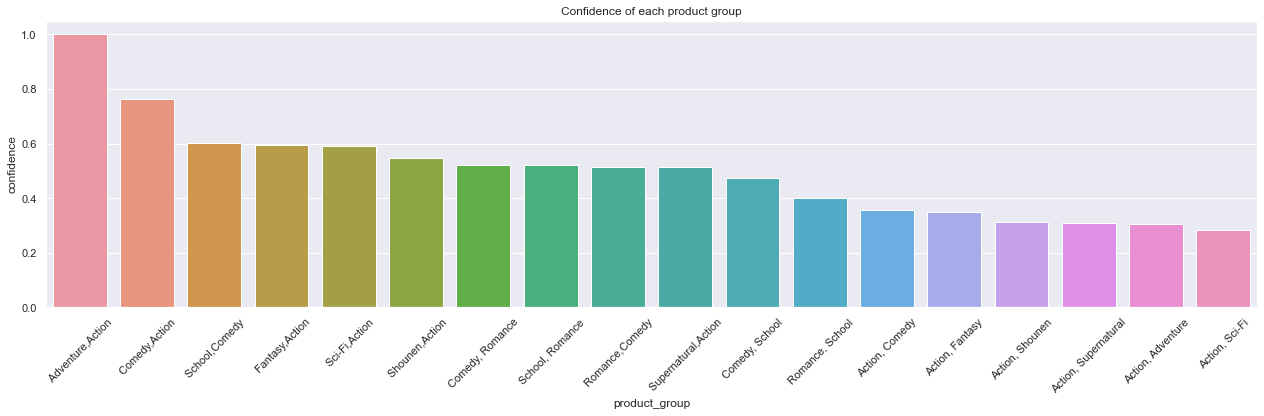

In [146]:
sns.set(font_scale=0.4) 
sns.set(rc={'figure.figsize':(21.7,5.27)})
plt.title('Confidence of each product group')
plt.xticks(rotation=45)
sns.barplot(x="product_group",y="confidence",data=df2);

##### Inferences

* 100% of users who like Adventure animes are interested in Action animes but only 30% of users who like Action animes are interested in Adventure animes.


* The lift values of Adventure and Action animes are the highest (2.39 mutually).


* The lift values are equal for all mutual genres.


* 28% of users who like Action animes are interested in Science Fiction animes.


* Around 52% of users who like Comedy animes are interested in Romance animes and vice-versa.